# Libraries, Constants and Dataframe

In [1]:
import pandas as pd
import numpy as np

import ot
import fasttext
from scipy import spatial
from tqdm import tqdm
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from matplotlib import pyplot as plt

In [2]:
REVIEW = "Review"
LIKED = "Liked"

In [3]:
df_raw_comments = pd.read_csv("../resources/Restaurant_Reviews.tsv", sep='\t')
df_raw_comments.head()

,Review,Liked
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


In [4]:
text = df_raw_comments.iloc[:,0]
labels = df_raw_comments.iloc[:,1]

# Implementation

Created on 14/05/2019

- This is the adaptation and correction of 'Optimal transport for documents classification' given [here](http://www.lumenai.fr/blog/optimal-transport-for-documents-classification)
- I correct some mistakes in the code and I succed in reproducing the results.
- Now, I have to see for implementation in the classification I want to do

@author: JuanManuel.Aguiar

In [5]:
def train_fasttext(df: pd.DataFrame):
    text.to_csv("../resources/text.csv", index=False, header=False)
    return fasttext.train_unsupervised("../resources/text.csv", model='cbow')

In [6]:
fasttext_model = train_fasttext(df_raw_comments)

In [7]:
# dictionnary of embedding vectors : key = word and values = vector
rev = {}
for word in fasttext_model.words:
    rev[word] = fasttext_model[word]

In [8]:
def create_embedding_matrix(dict_rev: dict) -> np.array:
    return np.array([x.tolist() for x in dict_rev.values() if x.shape[0] != 1])

In [9]:
embedding_matrix = create_embedding_matrix(rev)
# embedding_matrix

In [10]:
def compute_words_distance(model: fasttext.FastText._FastText, embedded_matrix: np.array) -> np.array:
    C_light = spatial.distance.pdist(embedded_matrix)
    dim = len(model.words)
    values = C_light
    Z = np.zeros([dim,dim], dtype=np.double)
    Z[np.triu_indices(dim, k=1)] = values
    Z = Z + Z.T
    Z[np.diag_indices(dim)] = 0
    distance = Z
    M = np.array(distance)
    return M

In [11]:
distance_matrix = compute_words_distance(fasttext_model, embedding_matrix)
# distance_matrix

In [12]:
def compute_distribution(document, model):
    distr_A = []
    for word in model:
        if word not in document.split(" "):
            distr_A.append((word, 0))
        else:
            cpt = 0
            for elt in document.split(" "):
                if elt != word:
                    pass
                else:
                    cpt += 1
            distr_A.append((word, cpt))
    cpt = 0
    for elt in document.split(" "):
        if elt not in model:
            cpt += 1

    distribution = [x[1] / float(1+len(document.split(" ")) - cpt) for x in distr_A]

    return distribution

In [13]:
docs_histogs = []
for doc in tqdm(text, total=text.shape[0]):
    docs_histogs.append(compute_distribution(doc, fasttext_model.words))

100%|██████████| 1000/1000 [00:00<00:00, 2010.73it/s]


In [14]:
def Wasserstein_dist_OT(A, B, M, model):
    # Wasserstein distance between documents A and B from fasttext model
    # A and B string where words are spaced by " "
    # model is an object model.words from a fasttext model, ie list of unique words in the corpus 
    #(the code below allows A and B to contain words not in model.words)
    # X is the matrix of word embeddings from fasttext

    # Compute a the distribution of words in A
    a = compute_distribution(A, model)

    # Compute b the distribution of words in B
    b = compute_distribution(B, model)

    # solve OT problem with Python OT module
    Wd = ot.emd2(a, b, M)  # this is the exact linear program
    return Wd

In [15]:
# compute the WMD matrix from the set of documents in the train
def compute_WMD_matrix(matrix_size: int, model: fasttext.FastText._FastText, df: pd.DataFrame) -> dict:
    m = matrix_size
    res = [[Wasserstein_dist_OT(x, y, distance_matrix, model.words) for x in tqdm(df.iloc[:m, 0])] 
           for y in df.iloc[:m, 0]]
    D = np.array(res)
    return {"D":D, "res": res}

In [16]:
%%time
WMD_matrix = compute_WMD_matrix(1000, fasttext_model, df_raw_comments)

  0%|          | 0/1000 [00:00<?, ?it/s]/Users/nicolasrousseau/opt/anaconda3/lib/python3.7/site-packages/ot/lp/__init__.py:230: UserWarning: Problem infeasible. Check that a and b are in the simplex
  check_result(result_code)
100%|██████████| 1000/1000 [00:00<00:00, 1169.63it/s]


100%|██████████| 1000/1000 [00:00<00:00, 1036.24it/s]


100%|██████████| 1000/1000 [00:00<00:00, 1234.92it/s]


100%|██████████| 1000/1000 [00:00<00:00, 1269.83it/s]


100%|██████████| 1000/1000 [00:00<00:00, 1065.86it/s]


100%|██████████| 1000/1000 [00:01<00:00, 821.90it/s]


100%|██████████| 1000/1000 [00:01<00:00, 611.37it/s]

CPU times: user 17min 15s, sys: 13.3 s, total: 17min 29s
Wall time: 17min 33s


In [17]:
linked = linkage(WMD_matrix["res"], 'ward')

/Users/nicolasrousseau/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  """Entry point for launching an IPython kernel.


In [18]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
            
    return ddata

In [19]:
def plot_dendrogram(linkage: np.array) -> None:
    plt.figure(figsize=(10, 10))
    plt.grid(which='both', axis='y')
    fancy_dendrogram(
        linkage,
        truncate_mode='lastp',
        p=30,
        leaf_rotation=90.,
        leaf_font_size=8.,
        show_contracted=True,
        annotate_above=8,
        max_d=9.5,
    )
    return plt.show()

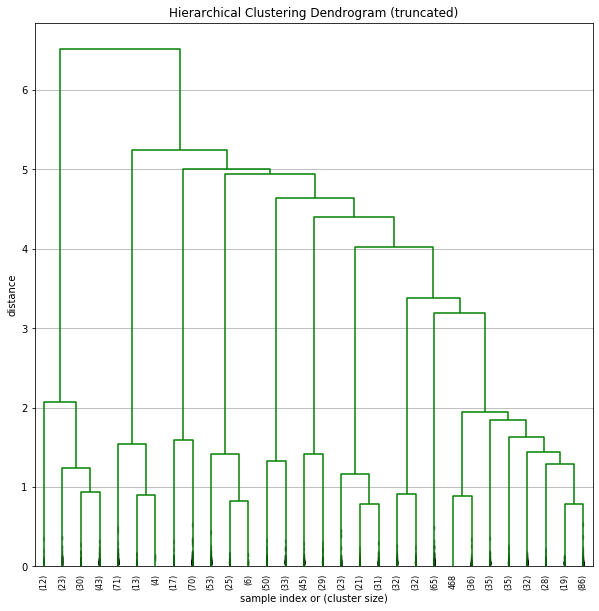

In [20]:
plot_dendrogram(linked)

In [21]:
def build_clustering_model(nb_clusters: int, wmd_matrix: list) -> np.array:
    model = AgglomerativeClustering(n_clusters=nb_clusters, affinity='euclidean', linkage='ward')
    cluster_hierarchy = model.fit(wmd_matrix)
    return cluster_hierarchy.labels_

In [22]:
cluster_number = build_clustering_model(10, WMD_matrix["res"])
# cluster_number

/Users/nicolasrousseau/opt/anaconda3/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:830: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


In [23]:
df_cluster_OT = pd.DataFrame(cluster_number, columns=['cluster_OT'])
df_cluster_OT.head()

,cluster_OT
0,7
1,0
2,4
3,6
4,1


In [24]:
# df_cluster_OT.to_csv("../resources/df_cluster_OT.csv", index=False, sep="," , encoding="utf-8")